# <center>HEC-5Q Comparison of<br>CalSimII Hydrology vs. CalSim3 Hydrology</center>
***
### Import Libraries

In [1]:
# Standard Libraries
import os
import sys
import datetime as dt
# Third Party Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

### Create Custom Functions

In [2]:
# Common conversation factors
cfs_to_taf = lambda x, days: x * 1.98347 * days / 1000
taf_to_cfs = lambda x, days: x * 1000 / (1.98347 * days)

### Set Parameters

In [3]:
# Set Plot Sytle
# plt.style.use('ggplot')
# Set Variable for DataFrame Slicing
All = slice(None)
# Set directory locations of data
Proj_Dir = (r'C:\Users\jshannon\Desktop\Projects\117302_TemperatureANN' +
            r'\3_FILES\2018-08-15_HEC-5Q_Results')
CS2_FP_Hy = '../CalSimII/Pre_Processed/CS2_Hydrology.xlsx'
CS2_FP_5Q = '../CalSimII/Pre_Processed/CS2_5Q_Hydrology.xlsx'
CS3_FP_Hy = '../CalSim3/Pre_Processed/CS3_Hydrology.xlsx'
CS3_FP_5Q = '../CalSim3/Pre_Processed/CS3_5Q_Hydrology.xlsx'
CS2_FP_WQ = '../CalSimII/Model/CS2_SRWQ.xlsx'
CS3_FP_WQ = '../CalSim3/Model/CS3_SRWQ.xlsx'

### Import data into DataFrames

In [4]:
xl_kwargs = {'header': [0,1,2,4,5,6,7,8,9,10,11],
             'index_col': 0,
             'parse_dates': True}
CS2_Hy_DF = pd.read_excel(CS2_FP_Hy, sheet_name='CS2_Hydrology', **xl_kwargs)
CS2_5Q_DF = pd.read_excel(CS2_FP_5Q, sheet_name='CS2_5Q_Hydrology', **xl_kwargs)
CS3_Hy_DF = pd.read_excel(CS3_FP_Hy, sheet_name='CS3_Hydrology', **xl_kwargs)
CS3_5Q_DF = pd.read_excel(CS3_FP_5Q, sheet_name='CS3_5Q_Hydrology', **xl_kwargs)
CS2_WQ_DF = pd.read_excel(CS2_FP_WQ, sheet_name='CS2_SRWQ', **xl_kwargs)
CS3_WQ_DF = pd.read_excel(CS3_FP_WQ, sheet_name='CS3_SRWQ', **xl_kwargs)

### Process DataFrames

In [5]:
# Fill Missing Data for Daily Data
CS2_5Q_DF.fillna(method='bfill', inplace=True)
CS3_5Q_DF.fillna(method='bfill', inplace=True)
CS2_WQ_DF.fillna(method='bfill', inplace=True)
CS3_WQ_DF.fillna(method='bfill', inplace=True)
CS2_5Q_DF.fillna(method='ffill', inplace=True)
CS3_5Q_DF.fillna(method='ffill', inplace=True)
CS2_WQ_DF.fillna(method='ffill', inplace=True)
CS3_WQ_DF.fillna(method='ffill', inplace=True)
# Resample daily data to monthly timestamp
# Since indices are immutable, Part E labels will remain the same
for col in CS2_5Q_DF.columns:
    if col[10].upper().strip()=='PER-AVER':
        CS2_5Q_DF[col] = CS2_5Q_DF[col].resample('M').mean()
    elif col[10].upper().strip()=='INST-VAL':
        CS2_5Q_DF[col] = CS2_5Q_DF[col].resample('M').last()
for col in CS3_5Q_DF.columns:
    if col[10].upper().strip()=='PER-AVER':
        CS3_5Q_DF[col] = CS3_5Q_DF[col].resample('M').mean()
    elif col[10].upper().strip()=='INST-VAL':
        CS3_5Q_DF[col] = CS3_5Q_DF[col].resample('M').last()
for col in CS2_WQ_DF.columns:
    if col[10].upper().strip()=='PER-AVER':
        CS2_WQ_DF[col] = CS2_WQ_DF[col].resample('M').mean()
    elif col[10].upper().strip()=='INST-VAL':
        CS2_WQ_DF[col] = CS2_WQ_DF[col].resample('M').last()
for col in CS3_WQ_DF.columns:
    if col[10].upper().strip()=='PER-AVER':
        CS3_WQ_DF[col] = CS3_WQ_DF[col].resample('M').mean()
    elif col[10].upper().strip()=='INST-VAL':
        CS3_WQ_DF[col] = CS3_WQ_DF[col].resample('M').last()
CS2_5Q_DF.dropna(how='all',inplace=True)
CS3_5Q_DF.dropna(how='all',inplace=True)
CS2_WQ_DF.dropna(how='all',inplace=True)
CS3_WQ_DF.dropna(how='all',inplace=True)
# Filter to have matching indices
s_date = dt.datetime.strptime('1921-10-31','%Y-%m-%d')
e_date = dt.datetime.strptime('2003-09-30','%Y-%m-%d')
CS2_Hy_DF = CS2_Hy_DF.loc[s_date:e_date,:]
CS2_5Q_DF = CS2_5Q_DF.loc[s_date:e_date,:]
CS3_Hy_DF = CS3_Hy_DF.loc[s_date:e_date,:]
CS3_5Q_DF = CS3_5Q_DF.loc[s_date:e_date,:]
CS2_WQ_DF = CS2_WQ_DF.loc[s_date:e_date,:]
CS3_WQ_DF = CS3_WQ_DF.loc[s_date:e_date,:]
# Convert CFS timeseries to TAF in-place
# TAF is preferred for Storage Balance Quality Control
# Since indices are immutable, Unit labels will remain the same
for col in CS2_Hy_DF.columns:
    if col[9].upper().strip()=='CFS':
        CS2_Hy_DF[[col]] = CS2_Hy_DF[[col]].apply(lambda x: cfs_to_taf(x, x.index.day))
for col in CS2_5Q_DF.columns:
    if col[9].upper().strip()=='CFS':
        CS2_5Q_DF[[col]] = CS2_5Q_DF[[col]].apply(lambda x: cfs_to_taf(x, x.index.day))
for col in CS3_Hy_DF.columns:
    if col[9].upper().strip()=='CFS':
        CS3_Hy_DF[[col]] = CS3_Hy_DF[[col]].apply(lambda x: cfs_to_taf(x, x.index.day))
for col in CS3_5Q_DF.columns:
    if col[9].upper().strip()=='CFS':
        CS3_5Q_DF[[col]] = CS3_5Q_DF[[col]].apply(lambda x: cfs_to_taf(x, x.index.day))
# Convert ACFT to TAF in-place
# Since indices are immutable, Unit labels will remain the same
for col in CS2_5Q_DF.columns:
    if col[9].upper().strip()=='ACFT':
        CS2_5Q_DF[[col]] = CS2_5Q_DF[[col]] / 1000
for col in CS3_5Q_DF.columns:
    if col[9].upper().strip()=='ACFT':
        CS3_5Q_DF[[col]] = CS3_5Q_DF[[col]] / 1000
# Notify User of successful preprocessing
print('Message Output: Data Preprocessing Complete!')

Message Output: Data Preprocessing Complete!


### Map DataFrames for Analysis

In [6]:
# Trinity River - Trinity and Lewiston Reservoirs
Col_Name = 'TRINITY STORAGE'
Section_Header = ('TRINITY','TRINITY','STORAGE',All)
CS2_Hy_DF[Col_Name] = CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'S1')].columns[0]]
CS2_5Q_DF[Col_Name] = CS2_5Q_DF[CS2_5Q_DF.loc[:,Section_Header].columns[0]]
CS3_Hy_DF[Col_Name] = CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'S_TRNTY')].columns[0]]
CS3_5Q_DF[Col_Name] = CS3_5Q_DF[CS3_5Q_DF.loc[:,Section_Header].columns[0]]

Col_Name = 'TRINITY INFLOW'
Section_Header = ('TRINITY','TRINITY','FLOW-IN_FIT',All)
CS2_Hy_DF[Col_Name] = CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'I1')].columns[0]]
CS2_5Q_DF[Col_Name] = CS2_5Q_DF[CS2_5Q_DF.loc[:,Section_Header].columns[0]]
CS3_Hy_DF[Col_Name] = CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'I_TRNTY')].columns[0]]
CS3_5Q_DF[Col_Name] = CS3_5Q_DF[CS3_5Q_DF.loc[:,Section_Header].columns[0]]

Col_Name = 'LEWISTON INFLOW'
Section_Header = ('TRINITY','LEWISTON','FLOW-IN',All)
CS2_Hy_DF[Col_Name] = CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'I100')].columns[0]]
CS2_5Q_DF[Col_Name] = CS2_5Q_DF[CS2_5Q_DF.loc[:,Section_Header].columns[0]]
CS3_Hy_DF[Col_Name] = (CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'I_LWSTN')].columns[0]] -
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'E_LWSTN')].columns[0]])
CS3_5Q_DF[Col_Name] = CS3_5Q_DF[CS3_5Q_DF.loc[:,Section_Header].columns[0]]

Col_Name = 'TRINITY OUTFLOW'
Section_Header = ('TRINITY','TRINITY','FLOW-OUT',All)
CS2_Hy_DF[Col_Name] = (CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'C1')].columns[0]] +
                       CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'F1')].columns[0]])
CS2_5Q_DF[Col_Name] = CS2_5Q_DF[CS2_5Q_DF.loc[:,Section_Header].columns[0]]
CS3_Hy_DF[Col_Name] = CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'C_TRNTY')].columns[0]]
CS3_5Q_DF[Col_Name] = CS3_5Q_DF[CS3_5Q_DF.loc[:,Section_Header].columns[0]]

# Clear Creek - Whiskeytown Reservoir
Col_Name = 'WHISKEYTOWN STORAGE'
Section_Header = ('CLEAR_CR','WHISKEYTOWN','STORAGE',All)
CS2_Hy_DF[Col_Name] = CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'S3')].columns[0]]
CS2_5Q_DF[Col_Name] = CS2_5Q_DF[CS2_5Q_DF.loc[:,Section_Header].columns[0]]
CS3_Hy_DF[Col_Name] = CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'S_WKYTN')].columns[0]]
CS3_5Q_DF[Col_Name] = CS3_5Q_DF[CS3_5Q_DF.loc[:,Section_Header].columns[0]]

Col_Name = 'WHISKEYTOWN INFLOW'
Section_Header = ('CLEAR_CR','WHISKEYTOWN','FLOW-IN_FIT',All)
CS2_Hy_DF[Col_Name] = CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'I3')].columns[0]]
CS2_5Q_DF[Col_Name] = CS2_5Q_DF[CS2_5Q_DF.loc[:,Section_Header].columns[0]]
CS3_Hy_DF[Col_Name] = CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'I_CLR025')].columns[0]]
CS3_5Q_DF[Col_Name] = CS3_5Q_DF[CS3_5Q_DF.loc[:,Section_Header].columns[0]]

Col_Name = 'WHISKEYTOWN OUTFLOW'
Section_Header = ('CLEAR_CR','WHISKEYTOWN','FLOW-OUT',All)
CS2_Hy_DF[Col_Name] = (CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'C3')].columns[0]] +
                       CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'F3')].columns[0]])
CS2_5Q_DF[Col_Name] = CS2_5Q_DF[CS2_5Q_DF.loc[:,Section_Header].columns[0]]
CS3_Hy_DF[Col_Name] = CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'C_WKYTN')].columns[0]]
CS3_5Q_DF[Col_Name] = CS3_5Q_DF[CS3_5Q_DF.loc[:,Section_Header].columns[0]]

Col_Name = 'WHISKEYTOWN DIVERSION'
Section_Header = ('CLEAR_CR','WHISKEYTOWN','FLOW-DIV',All)
CS2_Hy_DF[Col_Name] = (CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'D3')].columns[0]] +
                       CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'E3')].columns[0]])
CS2_5Q_DF[Col_Name] = CS2_5Q_DF[CS2_5Q_DF.loc[:,Section_Header].columns[0]]
CS3_Hy_DF[Col_Name] = (CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'D_WKYTN_SPT003')].columns[0]] +
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'D_WKYTN_02_PU')].columns[0]] +
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'D_WKYTN_WTPBUK')].columns[0]] +
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'D_WKYTN_WTPCSD')].columns[0]] +
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'E_WKYTN')].columns[0]])
CS3_5Q_DF[Col_Name] = CS3_5Q_DF[CS3_5Q_DF.loc[:,Section_Header].columns[0]]

Col_Name = 'WHISKEYTOWN EVAP'
Section_Header = ('CLEAR_CR','WHISKEYTOWN','FLOW-EVAP',All)
CS2_Hy_DF[Col_Name] = CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'E3')].columns[0]]
CS2_5Q_DF[Col_Name] = CS2_5Q_DF[CS2_5Q_DF.loc[:,Section_Header].columns[0]]
CS3_Hy_DF[Col_Name] = CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'E_WKYTN')].columns[0]]
CS3_5Q_DF[Col_Name] = CS3_5Q_DF[CS3_5Q_DF.loc[:,Section_Header].columns[0]]

# Sacramento River - Shasta Reservoir
Col_Name = 'SHASTA STORAGE'
Section_Header = ('SACRAMENTO','SHASTA','STORAGE',All)
CS2_Hy_DF[Col_Name] = (CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'S4')].columns[0]] +
                       CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'S44')].columns[0]])
CS2_5Q_DF[Col_Name] = CS2_5Q_DF[CS2_5Q_DF.loc[:,Section_Header].columns[0]]
CS3_Hy_DF[Col_Name] = CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'S_SHSTA')].columns[0]]
CS3_5Q_DF[Col_Name] = CS3_5Q_DF[CS3_5Q_DF.loc[:,Section_Header].columns[0]]

Col_Name = 'SHASTA INFLOW'
Section_Header = ('SACRAMENTO','SHASTA','FLOW-IN_FIT',All)
CS2_Hy_DF[Col_Name] = CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'I4')].columns[0]]
CS2_5Q_DF[Col_Name] = CS2_5Q_DF[CS2_5Q_DF.loc[:,Section_Header].columns[0]]
CS3_Hy_DF[Col_Name] = CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'I_SHSTA')].columns[0]]
CS3_5Q_DF[Col_Name] = CS3_5Q_DF[CS3_5Q_DF.loc[:,Section_Header].columns[0]]

Col_Name = 'SHASTA OUTFLOW'
Section_Header = ('SACRAMENTO','SHASTA','FLOW-OUT_FIT',All)
CS2_Hy_DF[Col_Name] = (CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'C4')].columns[0]] +
                       CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'F4')].columns[0]])
CS2_5Q_DF[Col_Name] = CS2_5Q_DF[CS2_5Q_DF.loc[:,Section_Header].columns[0]]
CS3_Hy_DF[Col_Name] = CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'C_SHSTA')].columns[0]]
CS3_5Q_DF[Col_Name] = CS3_5Q_DF[CS3_5Q_DF.loc[:,Section_Header].columns[0]]

Col_Name = 'SHASTA DIVERSION'
Section_Header = ('SACRAMENTO','SHASTA','FLOW-DIV',All)
CS2_Hy_DF[Col_Name] = CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'E4')].columns[0]]
CS2_5Q_DF[Col_Name] = CS2_5Q_DF[CS2_5Q_DF.loc[:,Section_Header].columns[0]]
CS3_Hy_DF[Col_Name] = (CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'E_SHSTA')].columns[0]] +
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'D_SHSTA_WTPJMS')].columns[0]])
CS3_5Q_DF[Col_Name] = CS3_5Q_DF[CS3_5Q_DF.loc[:,Section_Header].columns[0]]

# Stony Creek - Black Butte Reservoir
Col_Name = 'BLACK BUTTE STORAGE'
Section_Header = ('STONY_CR','BLACK BUTTE','STORAGE',All)
CS2_Hy_DF[Col_Name] = CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'S42')].columns[0]]
CS2_5Q_DF[Col_Name] = CS2_5Q_DF[CS2_5Q_DF.loc[:,Section_Header].columns[0]]
CS3_Hy_DF[Col_Name] = CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'S_BLKBT')].columns[0]]
CS3_5Q_DF[Col_Name] = CS3_5Q_DF[CS3_5Q_DF.loc[:,Section_Header].columns[0]]

Col_Name = 'BLACK BUTTE INFLOW'
Section_Header = ('STONY_CR','BLACK BUTTE','FLOW-IN',All)
CS2_Hy_DF[Col_Name] = (CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'I42')].columns[0]] +
                       CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'C41')].columns[0]])
CS2_5Q_DF[Col_Name] = CS2_5Q_DF[CS2_5Q_DF.loc[:,Section_Header].columns[0]]
CS3_Hy_DF[Col_Name] = (CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'I_BLKBT')].columns[0]] +
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'C_SGRGE')].columns[0]])
CS3_5Q_DF[Col_Name] = CS3_5Q_DF[CS3_5Q_DF.loc[:,Section_Header].columns[0]]

Col_Name = 'BLACK BUTTE OUTFLOW'
Section_Header = ('STONY_CR','BLACK BUTTE','FLOW-OUT',All)
CS2_Hy_DF[Col_Name] = (CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'C42')].columns[0]] +
                       CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'F42')].columns[0]])
CS2_5Q_DF[Col_Name] = CS2_5Q_DF[CS2_5Q_DF.loc[:,Section_Header].columns[0]]
CS3_Hy_DF[Col_Name] = CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'C_BLKBT')].columns[0]]
CS3_5Q_DF[Col_Name] = CS3_5Q_DF[CS3_5Q_DF.loc[:,Section_Header].columns[0]]

# Trinity River Flows
Col_Name = 'TRINITY DIVERSION'
Section_Header = ('TRINITY','TRINITY','FLOW-DIV',All)
CS2_Hy_DF[Col_Name] = CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'E1')].columns[0]]
CS2_5Q_DF[Col_Name] = CS2_5Q_DF[CS2_5Q_DF.loc[:,Section_Header].columns[0]]
CS3_Hy_DF[Col_Name] = CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'E_TRNTY')].columns[0]]
CS3_5Q_DF[Col_Name] = CS3_5Q_DF[CS3_5Q_DF.loc[:,Section_Header].columns[0]]

Col_Name = 'LEWISTON DIVERSION'
Section_Header = ('TRINITY','LEWISTON','FLOW-DIV',All)
CS2_Hy_DF[Col_Name] = CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'D100')].columns[0]]
CS2_5Q_DF[Col_Name] = CS2_5Q_DF[CS2_5Q_DF.loc[:,Section_Header].columns[0]]
CS3_Hy_DF[Col_Name] = CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'D_LWSTN_CCT011')].columns[0]]
CS3_5Q_DF[Col_Name] = CS3_5Q_DF[CS3_5Q_DF.loc[:,Section_Header].columns[0]]

# Sacramento River Flows
Col_Name = 'KESWICK DIVERSION'
Section_Header = ('SACRAMENTO','KESWICK','FLOW-DIV',All)
CS2_Hy_DF[Col_Name] = CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'E5')].columns[0]]
CS2_5Q_DF[Col_Name] = CS2_5Q_DF[CS2_5Q_DF.loc[:,Section_Header].columns[0]]
CS3_Hy_DF[Col_Name] = (CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'C_SHSTA')].columns[0]] +
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'D_WKYTN_SPT003')].columns[0]] +
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'D_WKYTN_02_PU')].columns[0]] +
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'D_WKYTN_WTPBUK')].columns[0]] +
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'D_WKYTN_WTPCSD')].columns[0]] -
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'C_KSWCK')].columns[0]])
CS3_5Q_DF[Col_Name] = CS3_5Q_DF[CS3_5Q_DF.loc[:,Section_Header].columns[0]]

Col_Name = 'ACID DIVERSION'
Section_Header = ('SACRAMENTO','ACID','FLOW-DIV',All)
CS2_Hy_DF[Col_Name] = (CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'C5')].columns[0]] -
                       CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'C104')].columns[0]])
CS2_5Q_DF[Col_Name] = CS2_5Q_DF[CS2_5Q_DF.loc[:,Section_Header].columns[0]]
CS3_Hy_DF[Col_Name] = (CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'C_KSWCK')].columns[0]] +
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'C_WKYTN')].columns[0]] -
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'C_SAC287')].columns[0]])
CS3_5Q_DF[Col_Name] = CS3_5Q_DF[CS3_5Q_DF.loc[:,Section_Header].columns[0]]

Col_Name = 'COW CREEK INFLOW'
Section_Header = ('SACRAMENTO','COW CR','FLOW-IN',All)
CS2_Hy_DF[Col_Name] = CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'C10801')].columns[0]]
CS2_5Q_DF[Col_Name] = CS2_5Q_DF[CS2_5Q_DF.loc[:,Section_Header].columns[0]]
CS3_Hy_DF[Col_Name] = (CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'C_SAC277')].columns[0]] -
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'C_SAC287')].columns[0]])
CS3_5Q_DF[Col_Name] = CS3_5Q_DF[CS3_5Q_DF.loc[:,Section_Header].columns[0]]

Col_Name = 'COTTONWOOD CREEK INFLOW'
Section_Header = ('SACRAMENTO','COTTONWOOD CR','FLOW-IN',All)
CS2_Hy_DF[Col_Name] = CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'C10802')].columns[0]]
CS2_5Q_DF[Col_Name] = CS2_5Q_DF[CS2_5Q_DF.loc[:,Section_Header].columns[0]]
CS3_Hy_DF[Col_Name] = (CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'C_SAC271')].columns[0]] -
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'C_SAC277')].columns[0]])
CS3_5Q_DF[Col_Name] = CS3_5Q_DF[CS3_5Q_DF.loc[:,Section_Header].columns[0]]

Col_Name = 'BATTLE CREEK INFLOW'
Section_Header = ('SACRAMENTO','BATTLE CR','FLOW-IN',All)
CS2_Hy_DF[Col_Name] = CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'C10803')].columns[0]]
CS2_5Q_DF[Col_Name] = CS2_5Q_DF[CS2_5Q_DF.loc[:,Section_Header].columns[0]]
CS3_Hy_DF[Col_Name] = (CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'C_SAC269')].columns[0]] -
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'C_SAC271')].columns[0]])
CS3_5Q_DF[Col_Name] = CS3_5Q_DF[CS3_5Q_DF.loc[:,Section_Header].columns[0]]

Col_Name = 'BEND BRIDGE INFLOW'
Section_Header = ('SACRAMENTO','BEND BRIDGE','FLOW-IN',All)
CS2_Hy_DF[Col_Name] = (CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'I109')].columns[0]] +
                       CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'R109')].columns[0]])
CS2_5Q_DF[Col_Name] = CS2_5Q_DF[CS2_5Q_DF.loc[:,Section_Header].columns[0]]
CS3_Hy_DF[Col_Name] = (CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'C_SAC259')].columns[0]] -
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'C_SAC269')].columns[0]])
CS3_5Q_DF[Col_Name] = CS3_5Q_DF[CS3_5Q_DF.loc[:,Section_Header].columns[0]]

Col_Name = 'BEND BRIDGE DIVERSION'
Section_Header = ('SACRAMENTO','BEND BRIDGE','FLOW-DIV',All)
CS2_Hy_DF[Col_Name] = CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'D109')].columns[0]]
CS2_5Q_DF[Col_Name] = CS2_5Q_DF[CS2_5Q_DF.loc[:,Section_Header].columns[0]]
CS3_Hy_DF[Col_Name] = (CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'C_SAC259')].columns[0]] -
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'C_SAC257')].columns[0]])
CS3_5Q_DF[Col_Name] = CS3_5Q_DF[CS3_5Q_DF.loc[:,Section_Header].columns[0]]

Col_Name = 'PAYNES CREEK INFLOW'
Section_Header = ('SACRAMENTO','PAYNES CR','FLOW-IN',All)
CS2_Hy_DF[Col_Name] = (CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'C11001')].columns[0]] +
                       CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'I112')].columns[0]])
CS2_5Q_DF[Col_Name] = CS2_5Q_DF[CS2_5Q_DF.loc[:,Section_Header].columns[0]]
CS3_Hy_DF[Col_Name] = (CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'C_SAC254')].columns[0]] -
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'C_SAC257')].columns[0]])
CS3_5Q_DF[Col_Name] = CS3_5Q_DF[CS3_5Q_DF.loc[:,Section_Header].columns[0]]

Col_Name = 'TC CANAL DIVERSION'
Section_Header = ('SACRAMENTO','TC CANAL','FLOW-DIV',All)
CS2_Hy_DF[Col_Name] = CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'D112')].columns[0]]
CS2_5Q_DF[Col_Name] = CS2_5Q_DF[CS2_5Q_DF.loc[:,Section_Header].columns[0]]
CS3_Hy_DF[Col_Name] = (CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'C_SAC254')].columns[0]] -
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'C_SAC247')].columns[0]])
CS3_5Q_DF[Col_Name] = CS3_5Q_DF[CS3_5Q_DF.loc[:,Section_Header].columns[0]]

Col_Name = '113 INFLOW'
Section_Header = ('SACRAMENTO','MANY 113 CR','FLOW-IN',All)
CS2_Hy_DF[Col_Name] = (CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'C11305')].columns[0]] +
                       CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'C11301')].columns[0]] +
                       CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'R113')].columns[0]] +
                       CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'R114A')].columns[0]] +
                       CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'R114B')].columns[0]] +
                       CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'R114C')].columns[0]])
CS2_5Q_DF[Col_Name] = CS2_5Q_DF[CS2_5Q_DF.loc[:,Section_Header].columns[0]]
CS3_Hy_DF[Col_Name] = (CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'C_SAC229')].columns[0]] -
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'C_SAC247')].columns[0]])
CS3_5Q_DF[Col_Name] = CS3_5Q_DF[CS3_5Q_DF.loc[:,Section_Header].columns[0]]

Col_Name = '113 DIVERSION'
Section_Header = ('SACRAMENTO','MISC 113','FLOW-DIV',All)
CS2_Hy_DF[Col_Name] = (CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'D113A')].columns[0]] +
                       CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'D113B')].columns[0]])
CS2_5Q_DF[Col_Name] = CS2_5Q_DF[CS2_5Q_DF.loc[:,Section_Header].columns[0]]
CS3_Hy_DF[Col_Name] = (CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'C_SAC229')].columns[0]] -
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'C_SAC217')].columns[0]])
CS3_5Q_DF[Col_Name] = CS3_5Q_DF[CS3_5Q_DF.loc[:,Section_Header].columns[0]]

Col_Name = 'GCID CANAL DIVERSION'
Section_Header = ('SACRAMENTO','GCID CANAL','FLOW-DIV',All)
CS2_Hy_DF[Col_Name] = CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'D114')].columns[0]]
CS2_5Q_DF[Col_Name] = CS2_5Q_DF[CS2_5Q_DF.loc[:,Section_Header].columns[0]]
CS3_Hy_DF[Col_Name] = (CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'C_SAC217')].columns[0]] -
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'C_SAC201')].columns[0]])
CS3_5Q_DF[Col_Name] = CS3_5Q_DF[CS3_5Q_DF.loc[:,Section_Header].columns[0]]

Col_Name = 'BIG CHICO CREEK INFLOW'
Section_Header = ('SACRAMENTO','BIG CHICO CR','FLOW-IN',All)
CS2_Hy_DF[Col_Name] = CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'C11501')].columns[0]]
CS2_5Q_DF[Col_Name] = CS2_5Q_DF[CS2_5Q_DF.loc[:,Section_Header].columns[0]]
CS3_Hy_DF[Col_Name] = (CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'C_SAC178')].columns[0]] +
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'SP_SAC193_BTC003')].columns[0]] + 
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'SP_SAC188_BTC003')].columns[0]] +
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'SP_SAC178_BTC003')].columns[0]] -
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'C_SAC201')].columns[0]] -
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'C_STN004')].columns[0]])
CS3_5Q_DF[Col_Name] = CS3_5Q_DF[CS3_5Q_DF.loc[:,Section_Header].columns[0]]

Col_Name = 'BUTTE-ORD INFLOW'
Section_Header = ('SACRAMENTO','BUTTE-ORD','FLOW-IN',All)
CS2_Hy_DF[Col_Name] = CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'I118')].columns[0]]
CS2_5Q_DF[Col_Name] = CS2_5Q_DF[CS2_5Q_DF.loc[:,Section_Header].columns[0]]
CS3_Hy_DF[Col_Name] = (CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'C_SAC169')].columns[0]] -
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'C_SAC178')].columns[0]])
CS3_5Q_DF[Col_Name] = CS3_5Q_DF[CS3_5Q_DF.loc[:,Section_Header].columns[0]]

Col_Name = 'BUTTE-ORD DIVERSION'
Section_Header = ('SACRAMENTO','BUTTE-ORD','FLOW-DIV',All)
CS2_Hy_DF[Col_Name] = (CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'I118')].columns[0]] +
                       CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'C115')].columns[0]] -
                       CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'C118')].columns[0]] -
                       CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'D117')].columns[0]])
CS2_5Q_DF[Col_Name] = CS2_5Q_DF[CS2_5Q_DF.loc[:,Section_Header].columns[0]]
CS3_Hy_DF[Col_Name] = (CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'C_SAC169')].columns[0]] -
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'C_SAC162')].columns[0]])
CS3_5Q_DF[Col_Name] = CS3_5Q_DF[CS3_5Q_DF.loc[:,Section_Header].columns[0]]

Col_Name = 'MOULTIN INFLOW'
Section_Header = ('SACRAMENTO','ABV MOULTIN','FLOW-IN',All)
CS2_Hy_DF[Col_Name] = (CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'I123')].columns[0]] +
                       CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'C17603')].columns[0]])
CS2_5Q_DF[Col_Name] = CS2_5Q_DF[CS2_5Q_DF.loc[:,Section_Header].columns[0]]
CS3_Hy_DF[Col_Name] = (CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'C_SAC122')].columns[0]] +
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'SP_SAC159_BTC003')].columns[0]] +
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'SP_SAC148_BTC003')].columns[0]] +
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'SP_SAC122_SBP021')].columns[0]] -
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'C_SAC146')].columns[0]] -
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'SP_SAC159_BTC003')].columns[0]] -
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'SP_SAC148_BTC003')].columns[0]])
CS3_5Q_DF[Col_Name] = CS3_5Q_DF[CS3_5Q_DF.loc[:,Section_Header].columns[0]]

Col_Name = 'MOULTIN DIVERSION'
Section_Header = ('SACRAMENTO','ABV MOULTIN','FLOW-DIV',All)
CS2_Hy_DF[Col_Name] = (CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'C118')].columns[0]] +
                       CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'I123')].columns[0]] +
                       CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'C17603')].columns[0]] -
                       CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'C124')].columns[0]])
CS2_5Q_DF[Col_Name] = CS2_5Q_DF[CS2_5Q_DF.loc[:,Section_Header].columns[0]]
CS3_Hy_DF[Col_Name] = (CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'C_SAC162')].columns[0]] -
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'C_SAC146')].columns[0]] -
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'SP_SAC159_BTC003')].columns[0]] -
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'SP_SAC148_BTC003')].columns[0]])
CS3_5Q_DF[Col_Name] = CS3_5Q_DF[CS3_5Q_DF.loc[:,Section_Header].columns[0]]

Col_Name = 'KNIGHTS DIVERSION'
Section_Header = ('SACRAMENTO','ABV KNIGHTS','FLOW-DIV',All)
CS2_Hy_DF[Col_Name] = (CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'C126')].columns[0]] -
                       CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'C129')].columns[0]])
CS2_5Q_DF[Col_Name] = CS2_5Q_DF[CS2_5Q_DF.loc[:,Section_Header].columns[0]]
CS3_Hy_DF[Col_Name] = (CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'C_SAC122')].columns[0]] -
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'C_SAC097')].columns[0]])
CS3_5Q_DF[Col_Name] = CS3_5Q_DF[CS3_5Q_DF.loc[:,Section_Header].columns[0]]

Col_Name = 'COLUSA DRAIN DIVERSION'
Section_Header = ('SACRAMENTO','COLUSA DRAIN','FLOW-DIV',All)
CS2_Hy_DF[Col_Name] = (CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'C129')].columns[0]] -
                       CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'C134')].columns[0]])
CS2_5Q_DF[Col_Name] = CS2_5Q_DF[CS2_5Q_DF.loc[:,Section_Header].columns[0]]
CS3_Hy_DF[Col_Name] = (CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'C_SAC097')].columns[0]] -
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'C_SAC091')].columns[0]])
CS3_5Q_DF[Col_Name] = CS3_5Q_DF[CS3_5Q_DF.loc[:,Section_Header].columns[0]]

# Stony Creek River Flows
Col_Name = 'BLACK BUTTE DIVERSION'
Section_Header = ('STONY_CR','BLACK BUTTE','FLOW-DIV',All)
CS2_Hy_DF[Col_Name] = (CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'E42')].columns[0]] +
                       CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'D42')].columns[0]])
CS2_5Q_DF[Col_Name] = CS2_5Q_DF[CS2_5Q_DF.loc[:,Section_Header].columns[0]]
CS3_Hy_DF[Col_Name] = CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'E_BLKBT')].columns[0]]
CS3_5Q_DF[Col_Name] = CS3_5Q_DF[CS3_5Q_DF.loc[:,Section_Header].columns[0]]

Col_Name = 'TC-GC-NET DIVERSION'
Section_Header = ('STONY_CR','TC-GC-NET','FLOW-DIV',All)
CS2_Hy_DF[Col_Name] = (CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'C42')].columns[0]] -
                       CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'C142A')].columns[0]])
CS2_5Q_DF[Col_Name] = CS2_5Q_DF[CS2_5Q_DF.loc[:,Section_Header].columns[0]]
CS3_Hy_DF[Col_Name] = (CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'C_BLKBT')].columns[0]] -
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'C_STN004')].columns[0]])
CS3_5Q_DF[Col_Name] = CS3_5Q_DF[CS3_5Q_DF.loc[:,Section_Header].columns[0]]

# Bypass weir flows - defined explicitly
Col_Name = 'ORD FERRY SPILL'
Section_Header = ('BYPASS','ORD FERRY SPILL','FLOW-DIV',All)
CS2_Hy_DF[Col_Name] = CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'D117')].columns[0]]
CS2_5Q_DF[Col_Name] = CS2_5Q_DF[CS2_5Q_DF.loc[:,Section_Header].columns[0]]
CS3_Hy_DF[Col_Name] = (CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'SP_SAC193_BTC003')].columns[0]] +
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'SP_SAC188_BTC003')].columns[0]] +
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'SP_SAC178_BTC003')].columns[0]])
CS3_5Q_DF[Col_Name] = CS3_5Q_DF[CS3_5Q_DF.loc[:,Section_Header].columns[0]]

Col_Name = 'MOULTIN WEIR'
Section_Header = ('BYPASS','MOULTIN WEIR','FLOW-DIV',All)
CS2_Hy_DF[Col_Name] = CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'D124')].columns[0]]
CS2_5Q_DF[Col_Name] = CS2_5Q_DF[CS2_5Q_DF.loc[:,Section_Header].columns[0]]
CS3_Hy_DF[Col_Name] = CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'SP_SAC159_BTC003')].columns[0]]
CS3_5Q_DF[Col_Name] = CS3_5Q_DF[CS3_5Q_DF.loc[:,Section_Header].columns[0]]

Col_Name = 'COLUSA WEIR'
Section_Header = ('BYPASS','COLUSA WEIR','FLOW-DIV',All)
CS2_Hy_DF[Col_Name] = CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'D125')].columns[0]]
CS2_5Q_DF[Col_Name] = CS2_5Q_DF[CS2_5Q_DF.loc[:,Section_Header].columns[0]]
CS3_Hy_DF[Col_Name] = CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'SP_SAC148_BTC003')].columns[0]]
CS3_5Q_DF[Col_Name] = CS3_5Q_DF[CS3_5Q_DF.loc[:,Section_Header].columns[0]]

Col_Name = 'TISDALE WEIR'
Section_Header = ('BYPASS','TISDALE WEIR','FLOW-DIV',All)
CS2_Hy_DF[Col_Name] = CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'D126')].columns[0]]
CS2_5Q_DF[Col_Name] = CS2_5Q_DF[CS2_5Q_DF.loc[:,Section_Header].columns[0]]
CS3_Hy_DF[Col_Name] = CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'SP_SAC122_SBP021')].columns[0]]
CS3_5Q_DF[Col_Name] = CS3_5Q_DF[CS3_5Q_DF.loc[:,Section_Header].columns[0]]

# Sutter Bypass Flows
Col_Name = 'SUTTER REFUGE BYPASS'
Section_Header = ('BYPASS','SUTTER REFUGE','FLOW-DIV',All)
CS2_Hy_DF[Col_Name] = (CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'C136B')].columns[0]] -
                       CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'R137')].columns[0]] -
                       CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'R135A')].columns[0]] -
                       CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'R135B')].columns[0]] -
                       CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'C217A')].columns[0]])
CS2_5Q_DF[Col_Name] = CS2_5Q_DF[CS2_5Q_DF.loc[:,Section_Header].columns[0]]
CS3_Hy_DF[Col_Name] = (CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'SP_SAC193_BTC003')].columns[0]] +
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'SP_SAC188_BTC003')].columns[0]] +
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'SP_SAC178_BTC003')].columns[0]] +
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'SP_SAC159_BTC003')].columns[0]] +
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'SP_SAC148_BTC003')].columns[0]] -
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'C_SSL001')].columns[0]])
CS3_5Q_DF[Col_Name] = CS3_5Q_DF[CS3_5Q_DF.loc[:,Section_Header].columns[0]]

# QC - Reservoir mass balance
Col_Name = 'TRINITY RESERVOIR QC'
Section_Header = ('SACRAMENTO','TRINITY','STOR_BAL',All)
CS2_Hy_DF[Col_Name] = (CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'S1')].columns[0]] +
                       CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'I1')].columns[0]] -
                       CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'E1')].columns[0]] -
                       CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'C1')].columns[0]] -
                       CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'F1')].columns[0]])
CS2_5Q_DF[Col_Name] = CS2_5Q_DF[CS2_5Q_DF.loc[:,Section_Header].columns[0]]
CS3_Hy_DF[Col_Name] = (CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'S_TRNTY')].columns[0]] +
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'I_TRNTY')].columns[0]] -
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'E_TRNTY')].columns[0]] -
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'C_TRNTY')].columns[0]])
CS3_5Q_DF[Col_Name] = CS3_5Q_DF[CS3_5Q_DF.loc[:,Section_Header].columns[0]]

Col_Name = 'WHISKEYTOWN RESERVOIR QC'
Section_Header = ('SACRAMENTO','WHISKEYTOWN','STOR_BAL',All)
CS2_Hy_DF[Col_Name] = (CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'S3')].columns[0]] +
                       CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'I3')].columns[0]] -
                       CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'E3')].columns[0]] -
                       CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'C3')].columns[0]] -
                       CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'D3')].columns[0]] +
                       CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'D100')].columns[0]] -
                       CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'F3')].columns[0]])
CS2_5Q_DF[Col_Name] = CS2_5Q_DF[CS2_5Q_DF.loc[:,Section_Header].columns[0]]
CS3_Hy_DF[Col_Name] = (CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'S_WKYTN')].columns[0]] +
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'I_CLR025')].columns[0]] -
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'E_WKYTN')].columns[0]] -
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'C_WKYTN')].columns[0]] -
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'D_WKYTN_SPT003')].columns[0]] -
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'D_WKYTN_02_PU')].columns[0]] -
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'D_WKYTN_WTPBUK')].columns[0]] -
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'D_WKYTN_WTPCSD')].columns[0]] +
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'D_LWSTN_CCT011')].columns[0]])
CS3_5Q_DF[Col_Name] = CS3_5Q_DF[CS3_5Q_DF.loc[:,Section_Header].columns[0]]

Col_Name = 'SHASTA RESERVOIR QC'
Section_Header = ('SACRAMENTO','SHASTA','STOR_BAL',All)
CS2_Hy_DF[Col_Name] = (CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'S4')].columns[0]] +
                       CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'I4')].columns[0]] -
                       CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'E4')].columns[0]] -
                       CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'C4')].columns[0]] -
                       CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'F4')].columns[0]])
CS2_5Q_DF[Col_Name] = CS2_5Q_DF[CS2_5Q_DF.loc[:,Section_Header].columns[0]]
CS3_Hy_DF[Col_Name] = (CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'S_SHSTA')].columns[0]] +
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'I_SHSTA')].columns[0]] -
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'E_SHSTA')].columns[0]] -
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'C_SHSTA')].columns[0]] -
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'D_SHSTA_WTPJMS')].columns[0]])
CS3_5Q_DF[Col_Name] = CS3_5Q_DF[CS3_5Q_DF.loc[:,Section_Header].columns[0]]

Col_Name = 'BLACK BUTTE RESERVOIR QC'
Section_Header = ('SACRAMENTO','BLACK BUTTE','STOR_BAL',All)
CS2_Hy_DF[Col_Name] = (CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'S42')].columns[0]] +
                       CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'I42')].columns[0]] +
                       CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'C41')].columns[0]] -
                       CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'E42')].columns[0]] -
                       CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'D42')].columns[0]] -
                       CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'C42')].columns[0]] -
                       CS2_Hy_DF[CS2_Hy_DF.loc[:,(All,'F42')].columns[0]])
CS2_5Q_DF[Col_Name] = CS2_5Q_DF[CS2_5Q_DF.loc[:,Section_Header].columns[0]]
CS3_Hy_DF[Col_Name] = (CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'S_BLKBT')].columns[0]] +
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'I_BLKBT')].columns[0]] +
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'C_SGRGE')].columns[0]] -
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'E_BLKBT')].columns[0]] -
                       CS3_Hy_DF[CS3_Hy_DF.loc[:,(All,'C_BLKBT')].columns[0]])
CS3_5Q_DF[Col_Name] = CS3_5Q_DF[CS3_5Q_DF.loc[:,Section_Header].columns[0]]

# Notify User that variables were successfully mapped
print('Message Output: Variable Mapping Complete!')

Message Output: Variable Mapping Complete!


### Produce Regression Score Table
**Expectations:**
1. All scores should be close or equal to 1 except for Storage Balance Quality Control variables.
2. Storage Balance Quality Control variables from HEC-5Q data sets should be less than their CalSim counterparts. See Note 1 for reasoning. Visually inspect timeseries to ensure general patterns are similar between CalSim and HEC-5Q.

**Notes:**
1. Storage Balance Quality Control variables will not be equal because HEC-5Q data was resampled to an instantaneous monthly timestep, which exclude the accumulation of inflow and outflow during the month.

In [7]:
# Calculate R2_Scores
scores_CS2 = []
scores_CS3 = []
for col in CS2_Hy_DF.columns:
    if col[1]=='':
        Column_Name = col[0]
        score_CS2 = r2_score(CS2_Hy_DF[col],CS2_5Q_DF[col])
        mse_CS2 = mean_squared_error(CS2_Hy_DF[col],CS2_5Q_DF[col])
        score_CS3 = r2_score(CS3_Hy_DF[col],CS3_5Q_DF[col])
        mse_CS3 = mean_squared_error(CS3_Hy_DF[col],CS3_5Q_DF[col])
        scores_CS2.append([Column_Name,score_CS2,mse_CS2])
        scores_CS3.append([Column_Name,score_CS3,mse_CS3])
Scores_CS2_DF = pd.DataFrame(scores_CS2, columns=['Column Name','Score','MSE'])
Scores_CS3_DF = pd.DataFrame(scores_CS3, columns=['Column Name','Score','MSE'])
Scores_CS2_DF.set_index('Column Name', drop=True, inplace=True)
Scores_CS3_DF.set_index('Column Name', drop=True, inplace=True)
Scores_DF = pd.concat([Scores_CS2_DF,Scores_CS3_DF],axis=1,keys=['CS2','CS3'],names=['Model','Metric'])
# Show Scores
Scores_DF.sort_values(by=('CS2','Score'), axis=0, inplace=True, ascending=False)
Scores_DF.xs('Score',axis=1,level=1)

Model,CS2,CS3
Column Name,,
BEND BRIDGE DIVERSION,1.000000,1.000000
COLUSA DRAIN DIVERSION,1.000000,1.000000
GCID CANAL DIVERSION,1.000000,1.000000
BIG CHICO CREEK INFLOW,1.000000,1.000000
BATTLE CREEK INFLOW,1.000000,1.000000
COTTONWOOD CREEK INFLOW,1.000000,1.000000
COW CREEK INFLOW,1.000000,1.000000
ACID DIVERSION,1.000000,1.000000
KESWICK DIVERSION,1.000000,1.000000


### Select Plot

('COTTONWOOD CREEK INFLOW', '', '', '', '', '', '', '', '', '', '')


C:\Users\jshannon\AppData\Roaming\Continuum\anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


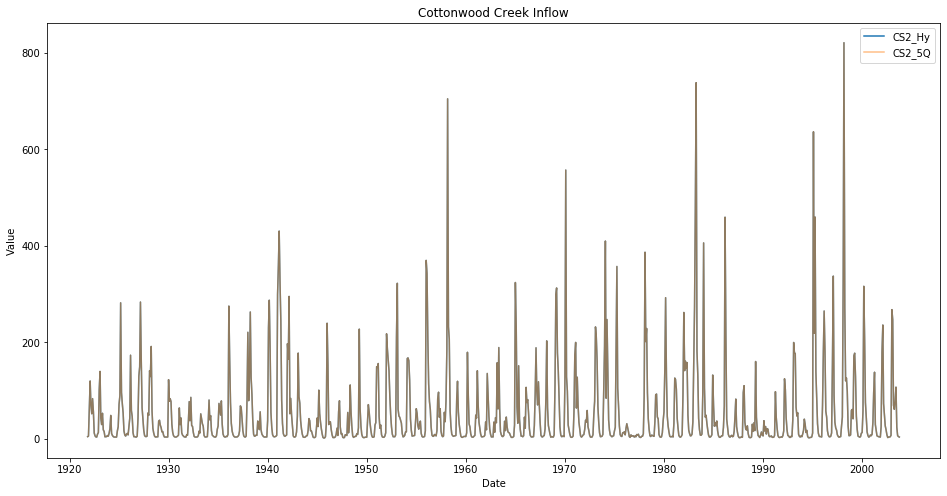

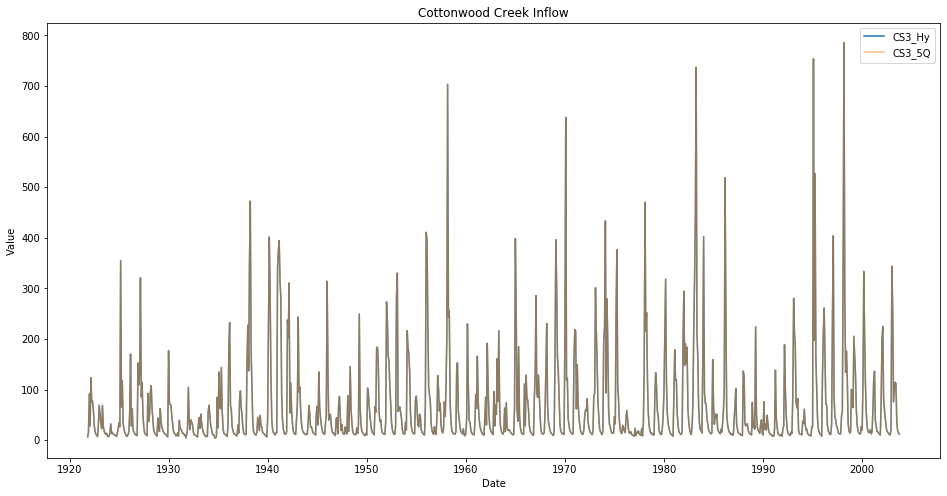

In [8]:
# Select column name
col_n = 'COTTONWOOD CREEK INFLOW'
col_n = CS2_Hy_DF.loc[:,(col_n,All)].columns[0]
# Plot CS2 Timeseries
fig_CS2, ax_CS2 = plt.subplots(1,figsize=(16,8))
print(CS2_Hy_DF[col_n].name)
ax_CS2.plot(CS2_Hy_DF[col_n], label='CS2_Hy')
ax_CS2.plot(CS2_5Q_DF[col_n], label='CS2_5Q', alpha=0.5)
ax_CS2.set_xlabel('Date')
ax_CS2.set_ylabel('Value')
ax_CS2.legend()
ax_CS2.set_title(col_n[0].title())
# Plot CS3 Timeseries
fig_CS3, ax_CS3 = plt.subplots(1,figsize=(16,8))
ax_CS3.plot(CS3_Hy_DF[col_n], label='CS3_Hy')
ax_CS3.plot(CS3_5Q_DF[col_n], label='CS3_5Q', alpha=0.5)
ax_CS3.set_xlabel('Date')
ax_CS3.set_ylabel('Value')
ax_CS3.legend()
ax_CS3.set_title(col_n[0].title())
# Show Figures
plt.show()

### Cross Model Comparison
**Expectations:**
1. A perfect comparison is when Score is equal to 1.
2. Variables close to, but not not equal to 1, may attribute differences due to the following:
    1. Model Hydrologic assumptions;
    2. Model Level of Development & Demand Assumptions.
3. Difference in downstream nodes may be acceptable if differences in upstream notes are accepted.

In [9]:
# Calculate R2_Scores
scores_CS = []
for col in CS2_Hy_DF.columns:
    if col[1]=='':
        Column_Name = col[0]
        score_CS = r2_score(CS2_Hy_DF[col],CS3_Hy_DF[col])
        mse_CS = mean_squared_error(CS2_Hy_DF[col],CS3_Hy_DF[col])
        AA_CS2 = CS2_Hy_DF[col].mean()
        AA_CS3 = CS3_Hy_DF[col].mean()
        scores_CS.append([Column_Name,score_CS,mse_CS,AA_CS2,AA_CS3,'Incomplete Analysis.'])
Scores_CS_DF = pd.DataFrame(scores_CS, columns=['Column Name',
                                                'Score',
                                                'MSE',
                                                'Annual Ave (CS2)',
                                                'Annual Ave (CS3)',
                                                'Analysis'])
Scores_CS_DF.set_index('Column Name', drop=True, inplace=True)
Scores_CS_DF.sort_values(by='Annual Ave (CS2)', axis=0, inplace=True, ascending=False)
Scores_CS_DF.sort_values(by='Score', axis=0, inplace=True, ascending=False)
# Comparison Analysis
Comparison_Analysis = {
'SHASTA INFLOW':
    'Acceptable; see Expectation #2A. CS2 is wetter in Wet Water Year Types.',
'BLACK BUTTE INFLOW':
    'Acceptable; see Expectation #2A. Slight differences in Wet Water Year Types.',
'TRINITY INFLOW':
    '''Acceptable; see Expectation #2A. CS2 is wetter in Wet Water Year Types. CS3 is
    wetter in summer months.''',
'WHISKEYTOWN INFLOW':
    'Acceptable; see Expectation #2A. CS2 is wetter in Wet & Above-Normal Water Year Types.',
'COW CREEK INFLOW':
    '''Acceptable; see Expectations #2A & 2B. CS3 is much higher because this in this inflow
    includes returns from Settlement Contractors.''',
'COTTONWOOD CREEK INFLOW':
    '''Acceptable; see Expectations #2A & 2B. CS3 is much higher because this inflow
    includes returns from Settlement Contractors.''',
'SHASTA DIVERSION':
    'Acceptable; see Expectations #2A & 2B.',
'SHASTA RESERVOIR QC':
    'Acceptable; see Expectations #2A & 2B.',
'SHASTA STORAGE':
    'Acceptable; see Expectations #2A & 2B.',
'SHASTA OUTFLOW':
    'Acceptable; see Expectations #2A & 2B.',
'TRINITY STORAGE':
    'Acceptable; see Expectations #2A & 2B.',
'TRINITY RESERVOIR QC':
    'Acceptable; see Expectations #2A & 2B.',
'BATTLE CREEK INFLOW':
    '''Acceptable; see Expectations #2A & 2B. CS3 is wetter in all Water Year Types 
    except in Wet ones. Wet Water Year Types are generally the same between the two 
    models. CS3 also includes returns from 03_NA as a part of this inflow.''',
'TRINITY OUTFLOW':
    'Acceptable; see Expectations #2A & 2B.',
'WHISKEYTOWN STORAGE':
    'Acceptable; see Expectations #2A & 2B.',
'WHISKEYTOWN RESERVOIR QC':
    'Acceptable; see Expectations #2A & 2B.',
'BLACK BUTTE STORAGE':
    'Acceptable; see Expectations #2A & 2B.',
'BLACK BUTTE RESERVOIR QC':
    'Acceptable; see Expectations #2A & 2B.',
'BLACK BUTTE OUTFLOW':
    'Acceptable; see Expectations #2A & 2B.',
'TRINITY DIVERSION':
    'Acceptable; see Expectations #2A & 2B.',
'WHISKEYTOWN OUTFLOW':
    'Acceptable; see Expectations #2A & 2B.',
'COLUSA WEIR':
    'Acceptable; see Expectation #2A & 2B.',
'BUTTE-ORD INFLOW':
    'Acceptable; differences due to CalSim3 groundwater simulation; see Expectation #2A & 2B.',
'TISDALE WEIR':
    'Acceptable; see Expectations #2A & 2B.',
'MOULTIN WEIR':
    'Acceptable; see Expectations #2A & 2B.',
}
# Store Analysis
for key, value in Comparison_Analysis.items():
    Scores_CS_DF.at[key,'Analysis'] = value
# Show resulting table
Scores_CS_DF[['Score','Annual Ave (CS2)','Annual Ave (CS3)','Analysis']].style

,Score,Annual Ave (CS2),Annual Ave (CS3),Analysis
Column Name,,,,
SHASTA INFLOW,0.973365,477.94,473.202,Acceptable; see Expectation #2A. CS2 is wetter in Wet Water Year Types.
BLACK BUTTE INFLOW,0.970946,34.3043,34.8563,Acceptable; see Expectation #2A. Slight differences in Wet Water Year Types.
TRINITY INFLOW,0.960008,106.564,103.802,Acceptable; see Expectation #2A. CS2 is wetter in Wet Water Year Types. CS3 is wetter in summer months.
WHISKEYTOWN INFLOW,0.959607,26.4575,23.7976,Acceptable; see Expectation #2A. CS2 is wetter in Wet & Above-Normal Water Year Types.
TRINITY STORAGE,0.933098,1522.08,1530.36,Acceptable; see Expectations #2A & 2B.
TRINITY RESERVOIR QC,0.929331,1521.88,1530.34,Acceptable; see Expectations #2A & 2B.
BLACK BUTTE OUTFLOW,0.921062,27.3512,33.664,Acceptable; see Expectations #2A & 2B.
SHASTA STORAGE,0.916514,3140.5,3094.25,Acceptable; see Expectations #2A & 2B.
BATTLE CREEK INFLOW,0.91288,28.5624,31.0446,Acceptable; see Expectations #2A & 2B. CS3 is wetter in all Water Year Types except in Wet ones. Wet Water Year Types are generally the same between the two models. CS3 also includes returns from 03_NA as a part of this inflow.


### Select Plot

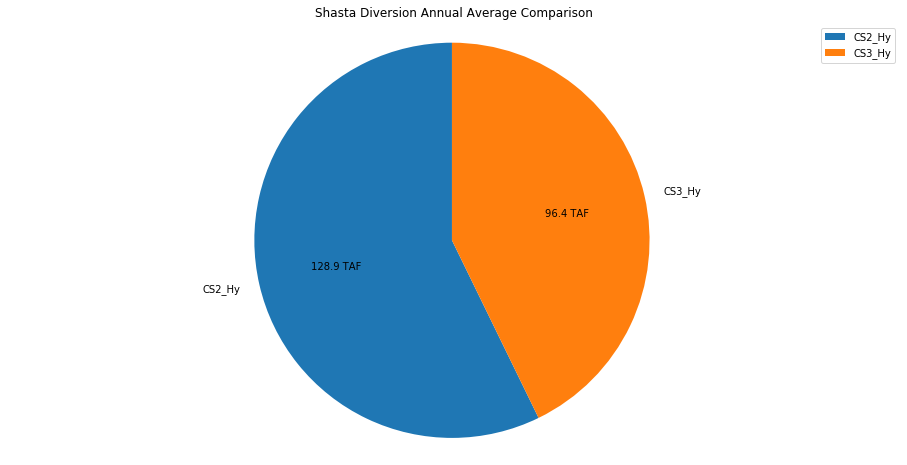

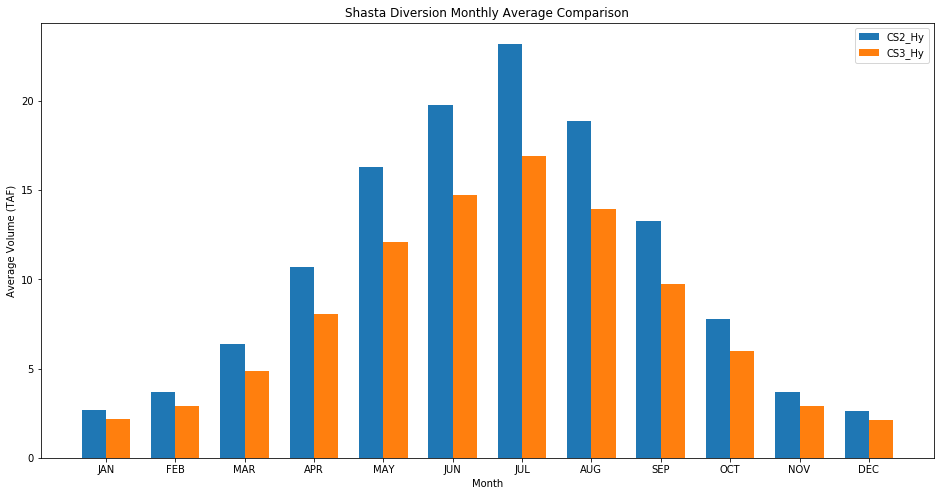

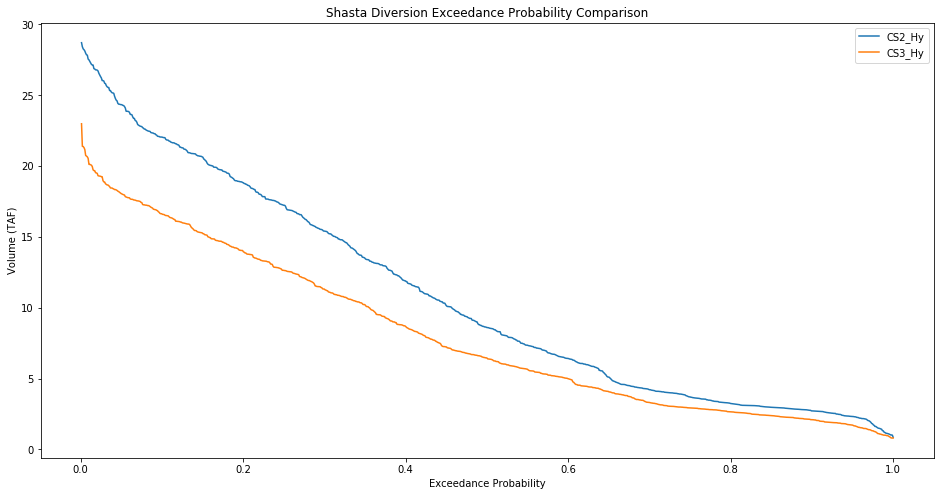

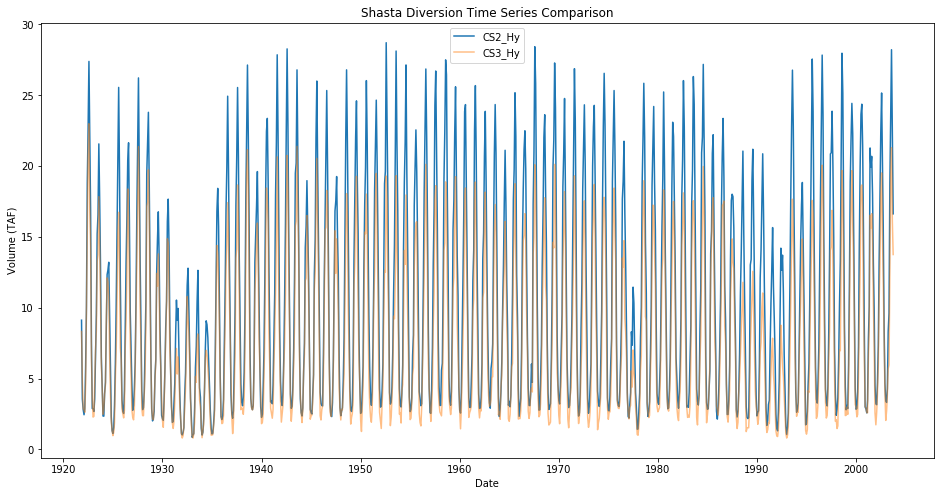

In [14]:
# Select column name
col_n_CS = 'SHASTA DIVERSION'
col_n_CS = (col_n_CS,All)
col_n_CS = CS2_Hy_DF.loc[:,col_n_CS].columns[0]
# Plot Annual Average
fig_AA, ax_AA = plt.subplots(1,figsize=(16,8))
if 'STORAGE' in col_n_CS:
    CS2_AA = CS2_Hy_DF[col_n_CS].mean()
    CS3_AA = CS3_Hy_DF[col_n_CS].mean()
else:
    CS2_AA = CS2_Hy_DF[col_n_CS].mean()*12
    CS3_AA = CS3_Hy_DF[col_n_CS].mean()*12
total = CS2_AA + CS3_AA
ax_AA.pie([CS2_AA,CS3_AA],
          labels=['CS2_Hy','CS3_Hy'],
          startangle=90,
          autopct=lambda p: '{:,.1f} TAF'.format(p/100*total))
ax_AA.axis('equal')
ax_AA.legend()
ax_AA.set_title('{} Annual Average Comparison'.format(col_n_CS[0].title()))
# Plot Monthly Averages
fig_MA, ax_MA = plt.subplots(1,figsize=(16,8))
bar_width = 0.35
CS2_MA = CS2_Hy_DF[col_n_CS].groupby(CS2_Hy_DF.index.month).mean()
CS3_MA = CS3_Hy_DF[col_n_CS].groupby(CS3_Hy_DF.index.month).mean()
ax_MA.bar(CS2_MA.index, CS2_MA, bar_width, label='CS2_Hy')
ax_MA.bar(CS3_MA.index+bar_width, CS3_MA, bar_width, label='CS3_Hy')
ax_MA.set_xlabel('Month')
ax_MA.set_ylabel('Average Volume (TAF)')
ax_MA.set_title('{} Monthly Average Comparison'.format(col_n_CS[0].title()))
ax_MA.set_xticks(CS2_MA.index + bar_width / 2)
ax_MA.set_xticklabels(('JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC'))
ax_MA.legend()
# Plot Exceedance Values
fig_EX, ax_EX = plt.subplots(1,figsize=(16,8))
Ex_Prob = np.linspace(1, 0, num=CS2_Hy_DF[col_n_CS].size, endpoint=False)
CS2_Ex = CS2_Hy_DF[col_n_CS].sort_values().values
CS3_Ex = CS3_Hy_DF[col_n_CS].sort_values().values
ax_EX.plot(Ex_Prob, CS2_Ex, label='CS2_Hy')
ax_EX.plot(Ex_Prob, CS3_Ex, label='CS3_Hy')
ax_EX.set_xlabel('Exceedance Probability')
ax_EX.set_ylabel('Volume (TAF)')
ax_EX.set_title('{} Exceedance Probability Comparison'.format(col_n_CS[0].title()))
ax_EX.legend()
# Plot CS Timeseries
fig_TS, ax_TS = plt.subplots(1,figsize=(16,8))
ax_TS.plot(CS2_Hy_DF[col_n_CS], label='CS2_Hy')
ax_TS.plot(CS3_Hy_DF[col_n_CS], label='CS3_Hy', alpha=0.5)
ax_TS.set_xlabel('Date')
ax_TS.set_ylabel('Volume (TAF)')
ax_TS.legend()
ax_TS.set_title('{} Time Series Comparison'.format(col_n_CS[0].title()))
# Show Figures
plt.show()

### Temperature Result Comparison

In [15]:
# Calculate R2_Scores
scores_WQ = []
for col in CS2_WQ_DF.columns:
    Column_Name = r'{}/{}/{}'.format(*col[:3])
    score_WQ = r2_score(CS2_WQ_DF[col],CS3_WQ_DF[col])
    mse_WQ = mean_squared_error(CS2_WQ_DF[col],CS3_WQ_DF[col])
    AA_CS2_WQ = CS2_WQ_DF[col].mean()
    AA_CS3_WQ = CS3_WQ_DF[col].mean()
    scores_WQ.append([Column_Name,score_WQ,mse_WQ,AA_CS2_WQ,AA_CS3_WQ,'Incomplete Analysis.'])
Scores_WQ_DF = pd.DataFrame(scores_WQ, columns=['Column Name',
                                                'Score','MSE',
                                                'Annual Ave (CS2)',
                                                'Annual Ave (CS3)',
                                                'Analysis'])
Scores_WQ_DF.set_index('Column Name', drop=True, inplace=True)
Scores_WQ_DF.sort_values(by='Annual Ave (CS2)', axis=0, inplace=True, ascending=False)
Scores_WQ_DF.sort_values(by='Score', axis=0, inplace=True, ascending=False)
# Comparison Analysis
Comparison_Analysis_WQ = {
r'BYPASS/ABV SACRAMENTO/TEMP_F':
    'Analysis still incomplete.',
}
# Store Analysis
for key, value in Comparison_Analysis_WQ.items():
    Scores_WQ_DF.at[key,'Analysis'] = value
# Show resulting table
Scores_WQ_DF[['Score','Annual Ave (CS2)','Annual Ave (CS3)','Analysis']].style

,Score,Annual Ave (CS2),Annual Ave (CS3),Analysis
Column Name,,,,
BYPASS/ABV SACRAMENTO/TEMP_F,0.996431,67.8946,67.3799,Analysis still incomplete.
SACRAMENTO/KNIGHTS LDG/TEMP_F,0.986776,60.6017,60.7182,Incomplete Analysis.
SACRAMENTO/BUTTE_CITY/TEMP_F,0.979937,58.1057,58.0989,Incomplete Analysis.
CLEAR CREEK/ABV SACRAMENTO/TEMP_F,0.970932,51.8473,51.9842,Incomplete Analysis.
SACRAMENTO/WOODSON BRIDGE/TEMP_F,0.969656,55.462,55.4163,Incomplete Analysis.
SACRAMENTO/RED BLUFF DAM/TEMP_F,0.963912,54.436,54.4509,Incomplete Analysis.
SACRAMENTO/BUTTE_CITY/FLOW,0.962854,12632.9,12065,Incomplete Analysis.
SACRAMENTO/WOODSON BRIDGE/FLOW,0.955237,12551.6,12429.9,Incomplete Analysis.
SACRAMENTO/BEND BRIDGE/TEMP_F,0.955015,53.5691,53.6332,Incomplete Analysis.


### Select a Water Quality Plot

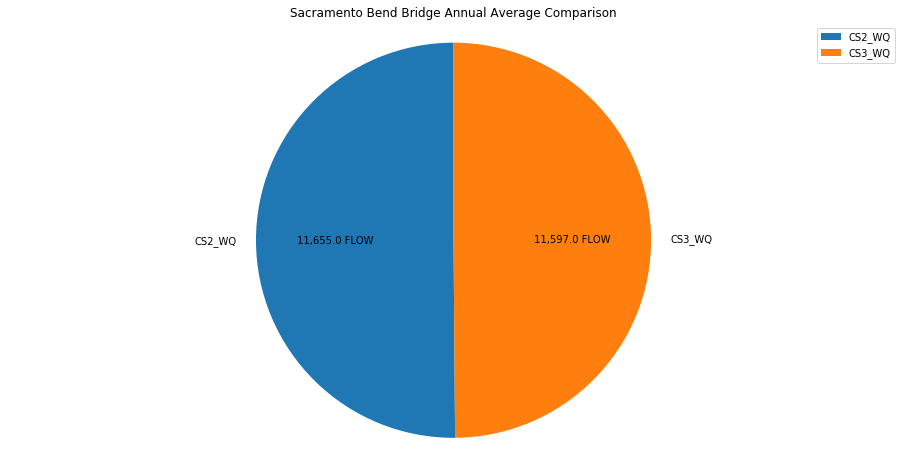

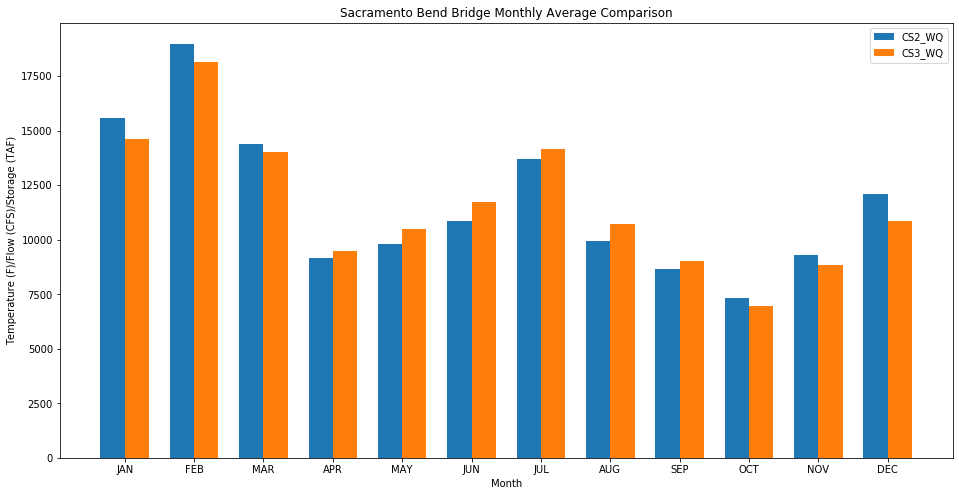

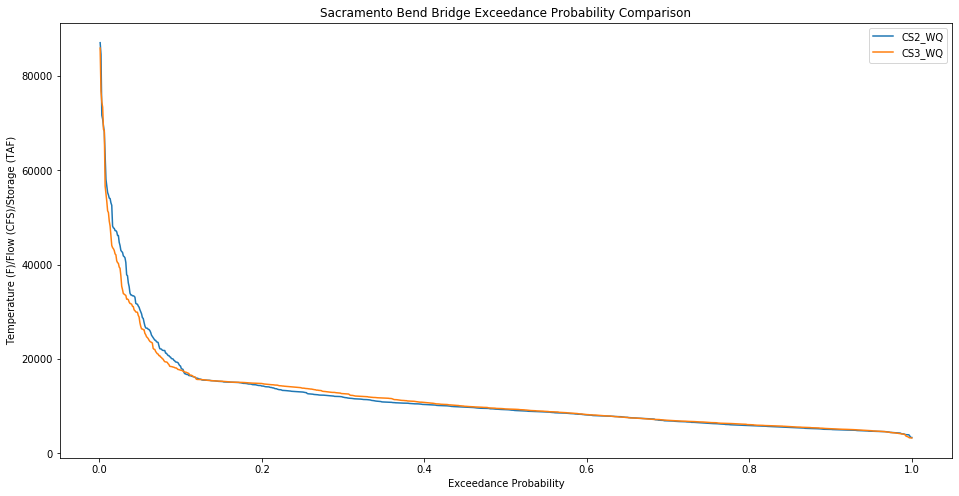

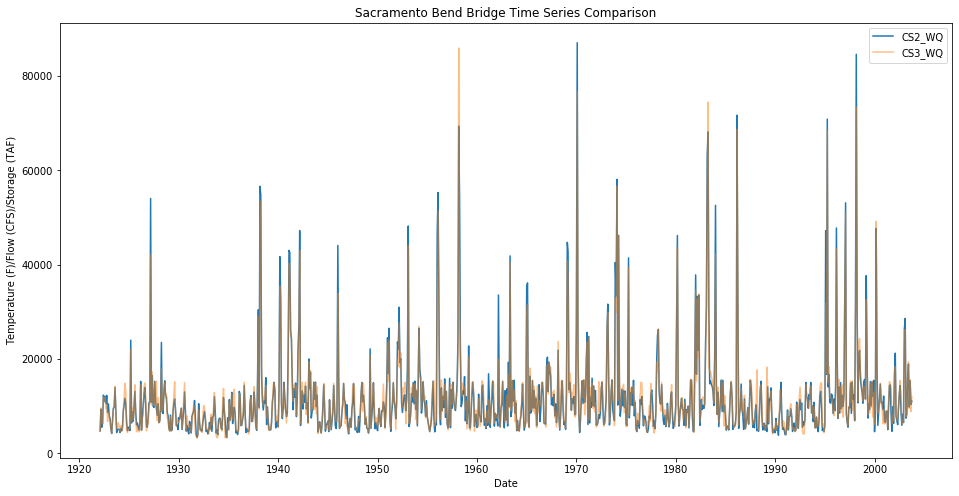

In [16]:
# Select column name
col_n_WQ = r'SACRAMENTO/BEND BRIDGE/FLOW'
col_n_WQ = col_n_WQ.split(r'/')
col_n_WQ.append(All)
col_n_WQ = tuple(col_n_WQ)
col_n_WQ = CS2_WQ_DF.loc[:,col_n_WQ].columns[0]
col_t_WQ = [x.title() for x in col_n_WQ[:2]]
# Plot Annual Average
fig_AA_WQ, ax_AA_WQ = plt.subplots(1,figsize=(16,8))
CS2_AA_WQ = CS2_WQ_DF[col_n_WQ].mean()
CS3_AA_WQ = CS3_WQ_DF[col_n_WQ].mean()
total_WQ = CS2_AA_WQ + CS3_AA_WQ
ax_AA_WQ.pie([CS2_AA_WQ,CS3_AA_WQ],
             labels=['CS2_WQ','CS3_WQ'],
             startangle=90,
             autopct=lambda p: '{:,.1f} {}'.format(p/100*total_WQ,col_n_WQ[2]))
ax_AA_WQ.axis('equal')
ax_AA_WQ.legend()
ax_AA_WQ.set_title('{} {} Annual Average Comparison'.format(*col_t_WQ))
# Plot Monthly Averages
fig_MA_WQ, ax_MA_WQ = plt.subplots(1,figsize=(16,8))
bar_width = 0.35
CS2_MA_WQ = CS2_WQ_DF[col_n_WQ].groupby(CS2_WQ_DF.index.month).mean()
CS3_MA_WQ = CS3_WQ_DF[col_n_WQ].groupby(CS3_WQ_DF.index.month).mean()
ax_MA_WQ.bar(CS2_MA_WQ.index, CS2_MA_WQ, bar_width, label='CS2_WQ')
ax_MA_WQ.bar(CS3_MA_WQ.index+bar_width, CS3_MA_WQ, bar_width, label='CS3_WQ')
ax_MA_WQ.set_xlabel('Month')
ax_MA_WQ.set_ylabel(r'Temperature (F)/Flow (CFS)/Storage (TAF)')
ax_MA_WQ.set_title('{} {} Monthly Average Comparison'.format(*col_t_WQ))
ax_MA_WQ.set_xticks(CS2_MA_WQ.index + bar_width / 2)
ax_MA_WQ.set_xticklabels(('JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC'))
ax_MA_WQ.legend()
# Plot Exceedance Values
fig_EX_WQ, ax_EX_WQ = plt.subplots(1,figsize=(16,8))
Ex_Prob_WQ = np.linspace(1, 0, num=CS2_WQ_DF[col_n_WQ].size, endpoint=False)
CS2_Ex_WQ = CS2_WQ_DF[col_n_WQ].sort_values().values
CS3_Ex_WQ = CS3_WQ_DF[col_n_WQ].sort_values().values
ax_EX_WQ.plot(Ex_Prob_WQ, CS2_Ex_WQ, label='CS2_WQ')
ax_EX_WQ.plot(Ex_Prob_WQ, CS3_Ex_WQ, label='CS3_WQ')
ax_EX_WQ.set_xlabel('Exceedance Probability')
ax_EX_WQ.set_ylabel(r'Temperature (F)/Flow (CFS)/Storage (TAF)')
ax_EX_WQ.set_title('{} {} Exceedance Probability Comparison'.format(*col_t_WQ))
ax_EX_WQ.legend()
# Plot CS Timeseries
fig_TS_WQ, ax_TS_WQ = plt.subplots(1,figsize=(16,8))
ax_TS_WQ.plot(CS2_WQ_DF[col_n_WQ], label='CS2_WQ')
ax_TS_WQ.plot(CS3_WQ_DF[col_n_WQ], label='CS3_WQ', alpha=0.5)
ax_TS_WQ.set_xlabel('Date')
ax_TS_WQ.set_ylabel(r'Temperature (F)/Flow (CFS)/Storage (TAF)')
ax_TS_WQ.legend()
ax_TS_WQ.set_title('{} {} Time Series Comparison'.format(*col_t_WQ))
# Show Figures
plt.show()

### Compliance Comparison

In [18]:
DF_Test = CS2_WQ_DF[[col_n_WQ]]
DF_Test_Ex = DF_Test.rank(method='first')
big = DF_Test_Ex.max()+1
DF_Test_Ex = DF_Test_Ex / big
print(DF_Test_Ex.max())

Part A:      Part B:         Part C:  Part E:  Part F:  Beg. Date:  Beg. Time:  End Date:   End Time:  Units:  Data Type:
CLEAR CREEK  ABV SACRAMENTO  TEMP_F   1DAY     SR       1922-01-01  2400        2003-09-30  2400       DEGF    PER-AVER      0.998982
dtype: float64
